# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [33]:
# Import numpy and pandas
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = [20,8]

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [3]:
# Run this code:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
# Your code here:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
# Your code here:
sensor.isnull().values.any()

False

How many rows and columns are in our data?

In [6]:
# Your code here:
rows, columns = sensor.shape
print(f"The dataframe has {rows} rows and {columns} columns.")

The dataframe has 1751 rows and 12 columns.


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
# Your code here:
new_index = pd.DatetimeIndex(pd.date_range('1/1/2018', periods=rows, freq='S'), freq='infer')
sensor['date'] = new_index
sensor.index = sensor['date'] 
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,date
date,,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,2018-01-01 00:00:00
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,2018-01-01 00:00:01
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,2018-01-01 00:00:02
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,2018-01-01 00:00:03
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,2018-01-01 00:00:04


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

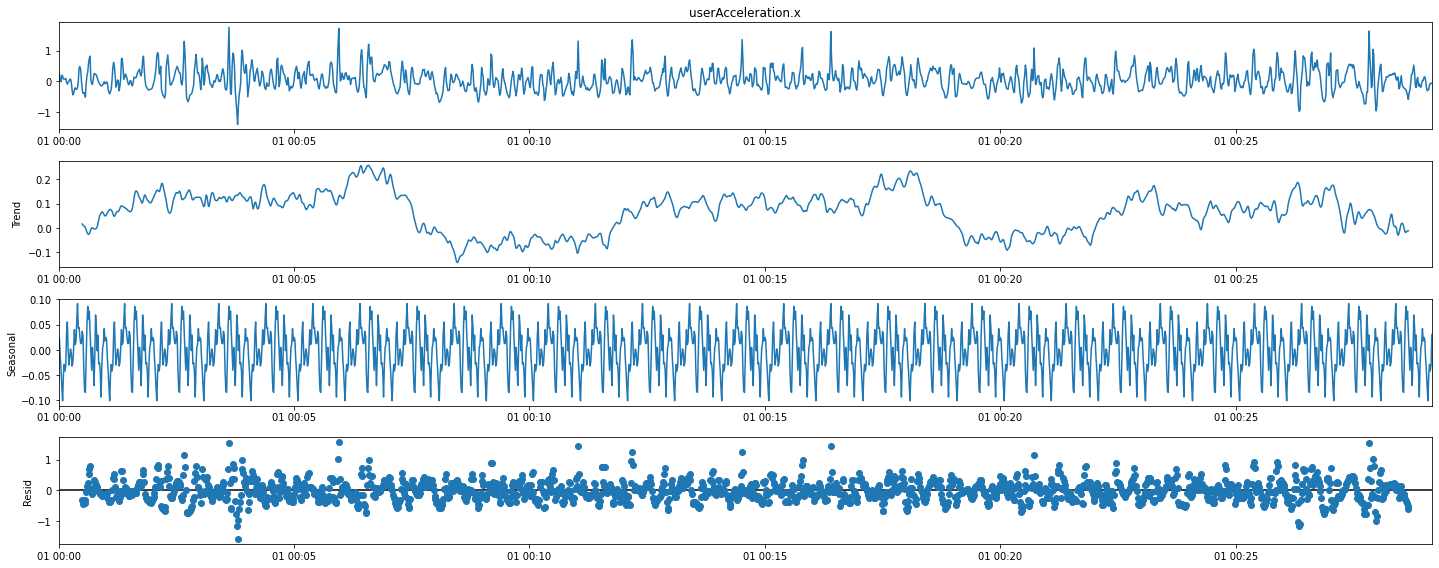

In [8]:
# Your code here:
decomp = seasonal_decompose(sensor['userAcceleration.x'], model='additive', period=60)
decomp.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

In [15]:
def autocorr(y, n=1):
    y_minus_n = y.iloc[:-n]
    y = y.iloc[n:]
    return np.corrcoef(y, y_minus_n)[0][1]

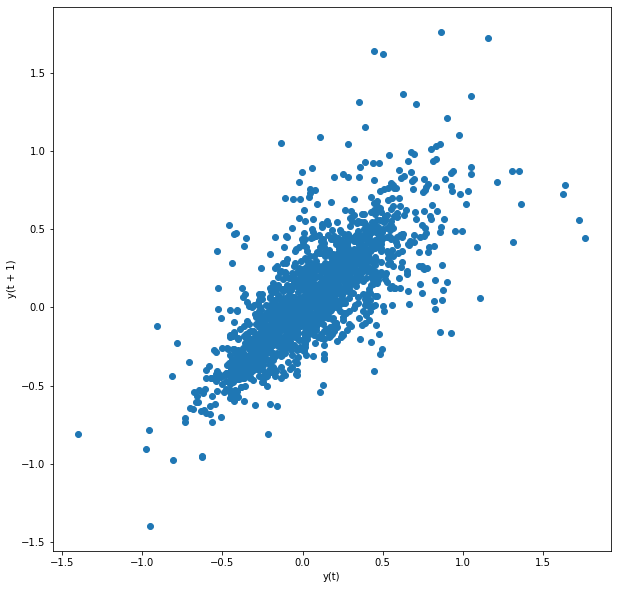

In [11]:
# Your code here:
plt.figure(figsize=(10,10))
pd.plotting.lag_plot(sensor['userAcceleration.x']);

In [22]:
autocorr(sensor['userAcceleration.x'], 1)

0.7597036239344239

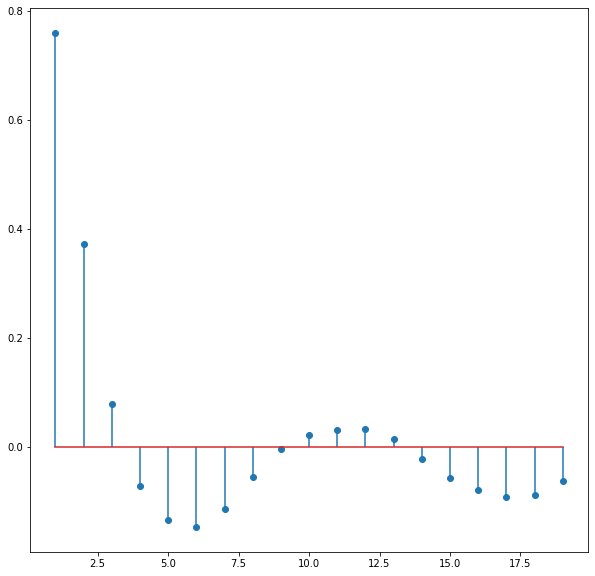

In [25]:
ac = [autocorr(sensor['userAcceleration.x'], i) for i in range(1,20)]
plt.figure(figsize=(10,10))
plt.stem(range(1,20), ac);

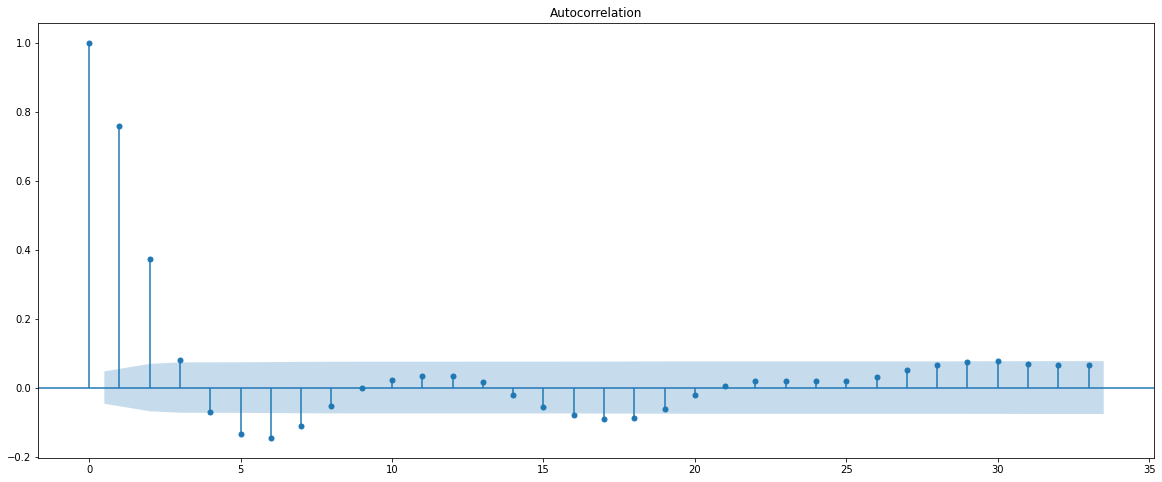

In [41]:
plot_acf(sensor['userAcceleration.x']);

Create a lag plot for `rotationRate.x`

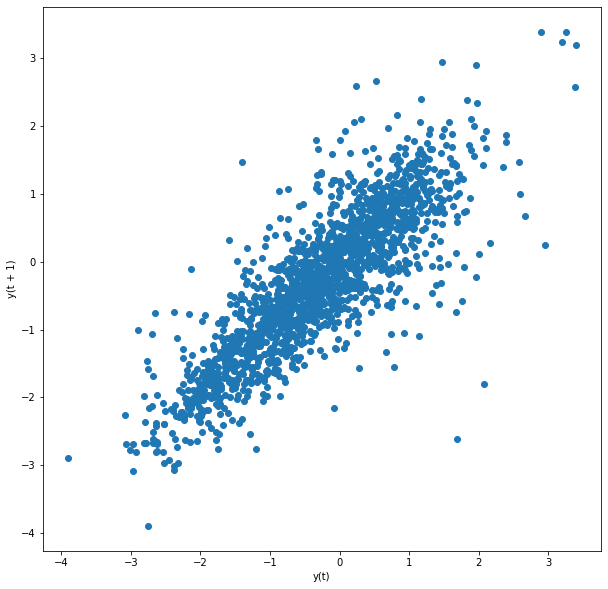

In [12]:
# Your code here:
plt.figure(figsize=(10,10))
pd.plotting.lag_plot(sensor['rotationRate.x']);

In [30]:
autocorr(sensor['rotationRate.x'], 1)

0.8470904664379265

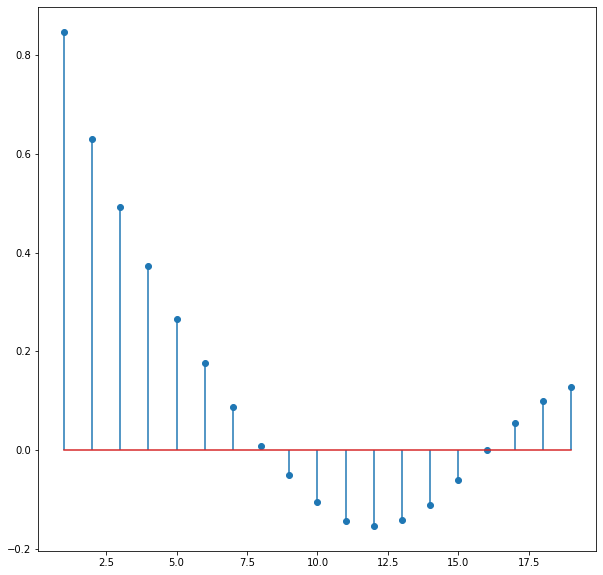

In [31]:
ac = [autocorr(sensor['rotationRate.x'], i) for i in range(1,20)]
plt.figure(figsize=(10,10))
plt.stem(range(1,20), ac);

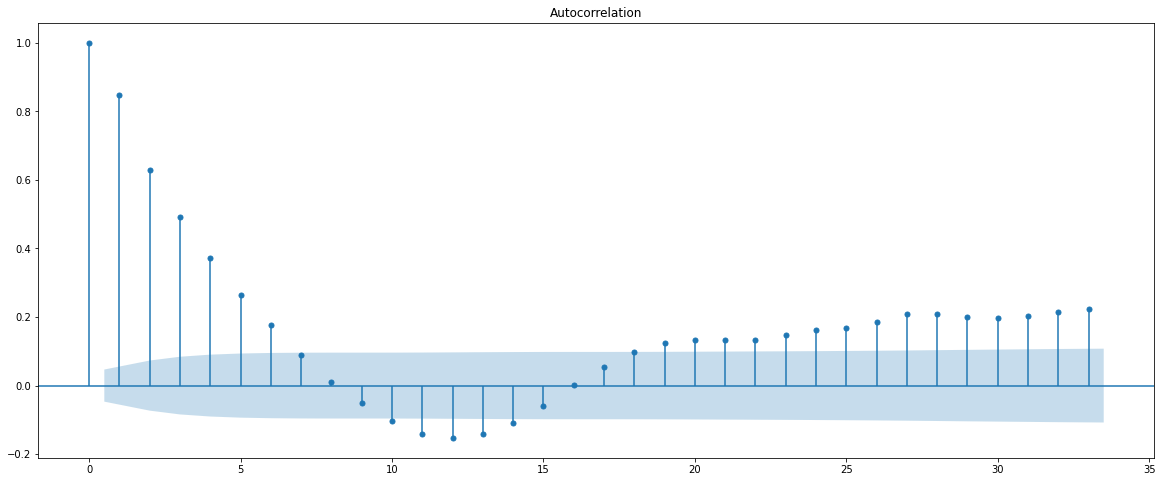

In [42]:
plot_acf(sensor['rotationRate.x']);

What are your conclusions from both visualizations?

In [13]:
# Your conclusions here:

# We can say both columns are, in general, positively correlated with themselves, which means that usually a value
# is useful in order to predict its consecutive. 

# Rotation Rate autocorrelation is a bit stronger than the Acceleration Rate, which has a few more outliers, and its points are not 
# clustered that tightly. 

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [18]:
# Your code here:
accel = adfuller(sensor['userAcceleration.x'])
rotat = adfuller(sensor['rotationRate.x'])
test_res = {'Acceleration': accel, 'Rotation': rotat}

for k in test_res:
    print(f"""Test for {k}:
     - T-statistic = {test_res[k][0]}
     - P-value = {test_res[k][1]}
     - Critical Values:
         * 1% = {test_res[k][4]['1%']}
         * 5% = {test_res[k][4]['5%']}
         * 10% = {test_res[k][4]['10%']}
    """)

Test for Acceleration:
     - T-statistic = -17.95799408616976
     - P-value = 2.823439483037483e-30
     - Critical Values:
         * 1% = -3.434100824760071
         * 5% = -2.863196780129223
         * 10% = -2.5676520210882936
    
Test for Rotation:
     - T-statistic = -5.269860625086415
     - P-value = 6.3202303359123905e-06
     - Critical Values:
         * 1% = -3.4341465551936534
         * 5% = -2.863216966926812
         * 10% = -2.567662770090317
    


What are your conclusions from this test?

In [13]:
# Your conclusions here:

# In the test for the Acceleration, we can observe that the p-value obtained is much lower than typical significance
# levels of 0.01, 0.05 or 0.1, and the t-statistic is smaller than any of the critical values, so we can reject
# the null hypothesis and say that our series is stationary. 

# In the test for the Rotation, we can observe similar results, as p-value is smaller than the typical significance
# levels, and the t-statistic is smaller than any of the critical values. Then, we can also reject the null hypothesis
# and say that the series is stationary.

# We can say that both series have no unit root, and them lagged levels provide some relevant info in predicting 
# changes over time.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [84]:
# Your code here:
train = [e for e in sensor['userAcceleration.x'][:-10].values]
test = sensor['userAcceleration.x'][-10:].values

predictions = []
for t in range(len(test)):
    mod = ARIMA(train, order=(2,0,2))
    mod_fit = mod.fit()
    result = mod_fit.forecast(10)
    yhat = result[0]
    predictions.append(yhat)
    obs = test[t]
    train.append(obs)
    print(f'predicted = {yhat}, expected = {obs}')
mse = mean_squared_error(test, predictions)

predicted = 0.17287889586295813, expected = 0.149749
predicted = 0.11564415735168906, expected = 0.038461
predicted = -0.008366628666798173, expected = -0.169175
predicted = -0.18629418573788734, expected = -0.300361
predicted = -0.2286861095776596, expected = -0.270174
predicted = -0.13590165854190497, expected = -0.268367
predicted = -0.16298969797041127, expected = -0.102444
predicted = 0.0351820521949711, expected = -0.08559
predicted = -0.04401140016280754, expected = -0.048105
predicted = 0.007285104889108912, expected = -0.065011


In [88]:
mod = ARIMA(train, order=(2,0,2))
mod_fit = mod.fit()
result = mod_fit.forecast(10)

rmse(result, test)

0.23050947499659036

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [85]:
# Your code here:
rmse(test, predictions)

0.09387559239937192